In [ ]:
!pip install nlpia

     |████████████████████████████████| 32.0MB 130kB/s 
     |████████████████████████████████| 716kB 50.4MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149826 sha256=5250b3f91cca95957f29bb433157686f4c16448293c4a0f885fe6bd4ae76717b
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
  Created wheel for pypandoc: filename=pypandoc-1.5-cp37-none-any.whl size=17036 sha256=eb8a14681b0d0489bda6739bba635ed0a9406b5417cac9244baf4ad299a6780f
  Stored in directory: /root/.cache/pip/wheels/bb/7d/d6/2f9af55e800d37e42e546106bcbd36a86e24e725e303d17e04
Successfully built python-Levenshtein pypandoc


In [ ]:
from nlpia.data.loaders import get_data

/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/usr/local/lib/python3.7/dist-packages/pugnlp/tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/pugnlp/util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
/usr/local/lib/python3.7/dist-packages/nlpia

In [ ]:
movies = get_data('hutto_movies')
movies.head()

,sentiment,text
id,,
1,2.266667,The Rock is destined to be the 21st Century's ...
2,3.533333,The gorgeously elaborate continuation of ''The...
3,-0.600000,Effective but too tepid biopic
4,1.466667,If you sometimes like to go to the movies to h...
5,1.733333,"Emerges as something rare, an issue movie that..."


In [ ]:
import pandas as pd
from nltk.tokenize import casual_tokenize
from collections import Counter

In [ ]:
from nltk.stem import PorterStemmer

# stemmer = PorterStemmer()

def vectorize(data):
  bag_of_words = []
  for review in data:
    review = casual_tokenize(review)
    # review = [stemmer.stem(word).strip("'") for word in review]
    bag_of_words.append(Counter(review))
  return bag_of_words

In [ ]:
data = vectorize(movies.text)
data = pd.DataFrame.from_records(data)
data.head()

,The,Rock,is,destined,to,be,the,21st,Century's,new,',Conan,and,that,he's,going,make,a,splash,even,greater,than,Arnold,Schwarzenegger,",",Jean,Claud,Van,Damme,or,Steven,Segal,.,gorgeously,elaborate,continuation,of,Lord,Rings,trilogy,...,Overwrought,snooze,Feeble,salaciously,Disjointed,humbuggery,Eh,unrealistic,nrelentingly,Painfully,Grating,Dramatically,Predictably,Arty,Incoherence,reigns,assed,Abysmally,Bland,ame,drudgery,snubbing,Mildly,Terrible,Degenerates,hogwash,Crummy,Wishy,Inconsequential,Insufferably,Ill,slummer,Rashomon,dipsticks,Bearable,Staggeringly,’,ve,muttering,dissing
0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = data.fillna(0).astype(int)
data.head()

,The,Rock,is,destined,to,be,the,21st,Century's,new,',Conan,and,that,he's,going,make,a,splash,even,greater,than,Arnold,Schwarzenegger,",",Jean,Claud,Van,Damme,or,Steven,Segal,.,gorgeously,elaborate,continuation,of,Lord,Rings,trilogy,...,Overwrought,snooze,Feeble,salaciously,Disjointed,humbuggery,Eh,unrealistic,nrelentingly,Painfully,Grating,Dramatically,Predictably,Arty,Incoherence,reigns,assed,Abysmally,Bland,ame,drudgery,snubbing,Mildly,Terrible,Degenerates,hogwash,Crummy,Wishy,Inconsequential,Insufferably,Ill,slummer,Rashomon,dipsticks,Bearable,Staggeringly,’,ve,muttering,dissing
0,1,1,1,1,2,1,1,1,1,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,1,0,0,0,4,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,1,4,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sms = get_data('sms-spam')

In [ ]:
sms.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(sms.text)
X.toarray()[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def lda_model(X, y):
  pos = X[y == 1]
  pos_centroid = pos.sum(axis=0) / len(pos)
  neg = X[y == 0]
  neg_centroid = neg.sum(axis=0) / len(neg)
  return pos_centroid - neg_centroid


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

X = X.toarray()

split = StratifiedShuffleSplit(n_splits=1, random_state=69)
for train_idx, test_idx in split.split(X, sms.spam):
  smsX_train, smsy_train = X[train_idx], sms.spam[train_idx]
  smsX_test, smsy_test = X[test_idx], sms.spam[test_idx]


In [ ]:
lda = lda_model(smsX_train, smsy_train)
min(smsX_train.dot(lda)), max(smsX_train.dot(lda))

(-0.02601550433321512, 0.060152918918890845)

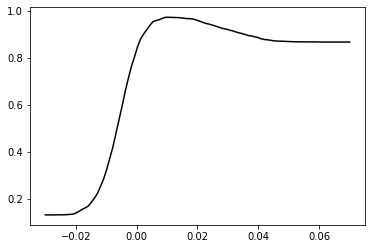

In [ ]:
import matplotlib.pyplot as plt

accuracy = lambda split_, X, y: sum(list(map(lambda x: 0 if x < split_ else 1, X.dot(lda))) == y) / len(y)

acc_ = []
max_accuracy = 0
decision_boundary = 0

for split_ in np.linspace(-0.03, 0.07, 100):
  acc = accuracy(split_, smsX_train, smsy_train)
  acc_.append(acc)
  if max_accuracy < acc:
    max_accuracy = acc
    decision_boundary = split_

plt.plot(np.linspace(-0.03, 0.07, 100), acc_, 'k-', label='Accuracy for different boundaries')
plt.show()

In [ ]:
max_accuracy, decision_boundary

(0.9738111647139903, 0.010404040404040402)

In [ ]:
accuracy(decision_boundary, smsX_test, smsy_test)

0.9793388429752066